<a href="https://www.kaggle.com/code/sonawanelalitsunil/jane-street-real-time-market-data-forecasting?scriptVersionId=210278312" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [2]:
import pandas as pd
import numpy as np
import polars as pl
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [5]:
# Statistical methods
from scipy.stats import pearsonr, spearmanr, kendalltau

In [6]:
from tqdm import tqdm

In [7]:
# Directory and constants
DATA_DIR = Path('/kaggle/input/jane-street-real-time-market-data-forecasting')
N_PARTITION = 10

In [8]:
# Feature columns and responder columns
feature_cols = [f'feature_{x:02}' for x in range(79)]
responder_cols = [f'responder_{i}' for i in range(9)]

In [9]:
os.listdir(DATA_DIR)

['responders.csv',
 'sample_submission.csv',
 'features.csv',
 'train.parquet',
 'lags.parquet',
 'test.parquet',
 'kaggle_evaluation']

#### Train data

In [10]:
os.listdir(DATA_DIR / "train.parquet")
nb_batches = len(os.listdir(DATA_DIR / "train.parquet"))
print(f"Nb of train batches {nb_batches}")

Nb of train batches 10


In [11]:
train_parquets = [f"train.parquet/partition_id={i}/part-0.parquet" for i in range(N_PARTITION)]
print(train_parquets)


['train.parquet/partition_id=0/part-0.parquet', 'train.parquet/partition_id=1/part-0.parquet', 'train.parquet/partition_id=2/part-0.parquet', 'train.parquet/partition_id=3/part-0.parquet', 'train.parquet/partition_id=4/part-0.parquet', 'train.parquet/partition_id=5/part-0.parquet', 'train.parquet/partition_id=6/part-0.parquet', 'train.parquet/partition_id=7/part-0.parquet', 'train.parquet/partition_id=8/part-0.parquet', 'train.parquet/partition_id=9/part-0.parquet']


In [12]:
import polars as pl

# Read the first partition from the list of parquet files
train_parquets = [DATA_DIR / f"train.parquet/partition_id={i}/part-0.parquet" for i in range(N_PARTITION)]
pl_train = pl.read_parquet(train_parquets[0])

# Inspect the columns and preview the first few rows
print("Columns in the dataset:", pl_train.columns)
print("First few rows of the dataset:")
print(pl_train.head())


Columns in the dataset: ['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'featu

In [13]:
pl_train.shape

(1944210, 92)

In [14]:
pl_train.head()

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,…,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,…,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,…,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,…,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
0,0,14,0.44057,null,null,null,null,null,0.9552,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,null,0.646086,null,-1.844685,-1.58656,-0.182024,null,-0.969949,-0.673813,-1.282132,-1.399894,null,null,0.043815,-0.320225,-0.031713,null,null,…,1.253902,null,null,0.476195,null,-0.771732,2.843421,null,1.379815,0.411827,-1.36224,null,null,null,null,null,-0.948601,-0.136814,-0.447704,-1.141761,0.099631,-0.661928,null,null,3.678076,2.793581,2.61825,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.0,-3.57282,-1.089123,-5.0


In [15]:
pl_train.describe()

statistic,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,…,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.94421e6,1.94421e6,1.94421e6,1.94421e6,0.0,0.0,0.0,0.0,0.0,1.94421e6,1.94421e6,1.94421e6,1.92723e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.889218e6,1.944147e6,1.934978e6,1.944151e6,1.944151e6,1.94421e6,0.0,1.94421e6,1.94421e6,1.94421e6,1.94421e6,0.0,0.0,1.94421e6,1.94421e6,1.94421e6,0.0,…,1.94192e6,1.88009e6,1.65109e6,1.94192e6,1.88009e6,1.944151e6,1.944151e6,1.922478e6,1.94421e6,1.94421e6,1.94421e6,1.790211e6,1.810936e6,1.807752e6,1.777836e6,1.777836e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.922478e6,1.922478e6,1.944194e6,1.944194e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6
"""null_count""",0.0,0.0,0.0,0.0,1.94421e6,1.94421e6,1.94421e6,1.94421e6,1.94421e6,0.0,0.0,0.0,16980.0,0.0,0.0,0.0,0.0,0.0,0.0,54992.0,63.0,9232.0,59.0,59.0,0.0,1.94421e6,0.0,0.0,0.0,0.0,1.94421e6,1.94421e6,0.0,0.0,0.0,1.94421e6,…,2290.0,64120.0,293120.0,2290.0,64120.0,59.0,59.0,21732.0,0.0,0.0,0.0,153999.0,133274.0,136458.0,166374.0,166374.0,0.0,0.0,0.0,0.0,0.0,0.0,21732.0,21732.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",93.846288,424.0,13.766376,1.973282,null,null,null,null,null,-0.044632,-0.006456,-0.019842,0.059797,28.628384,4.778166,168.016157,0.053623,0.03939,0.058634,0.331464,0.255926,0.32587,0.116747,0.034538,0.325885,null,0.429067,0.399052,-0.999268,0.196233,null,null,0.163988,-0.019372,0.381216,null,…,0.044491,0.118185,-0.092012,0.006591,-0.104968,-0.076846,-0.037126,-0.033732,-0.006372,-0.017632,-0.034067,0.649949,0.556831,0.580783,0.300181,0.231899,0.063448,0.037422,0.061478,0.04048,0.029071,0.048575,-0.118527,-0.120112,-0.083468,-0.084515,-0.096821,-0.098051,0.008425,0.010765,0.002413,0.011391,0.021855,0.003327,0.001488,-0.000482,0.001078
"""std""",48.131963,245.085082,11.087783,0.969197,null,null,null,null,null,0.947958,0.935119,0.967365,0.92284,23.910034,2.434048,174.221678,1.221367,1.301022,1.230007,1.105641,1.265235,1.173493,1.002713,1.038083,1.026575,null,0.943643,0.881062,0.734232,0.994776,null,null,0.937258,0.829064,1.08911,null,…,1.222116,1.045308,0.993687,1.225616,1.055472,1.024146,1.004834,0.979773,0.979413,0.98268,1.109674,2.686165,2.578012,2.651716,0.912934,0.908562,1.232994,1.317462,1.253779,1.243743,1.316291,1.270607,0.642401,0.6352,0.759618,0.754082,0.649495,0.639899,0.955878,1.141793,0.844203,1.276044,1.266448,1.225165,0.870577,0.891815,0.873732
"""min""",0.0,0.0,0.0,0.44057,null,null,null,null,null,-11.76608,-25.143543,-20.321791,-6.224619,4.0,1.0,11.0,-1.913078,-0.892107,-1.318024,-1.35983,-1.760566,-1.673085,-6.000734,-4.55074,-3.294369,null,-1.971631,-1.752133,-3.110884,-1.650518,null,null,-3.150075,-1.023257,-1.059913,null,…,-4.363397,-4.15804,-5.353856,-5.606056,-5.698468,-4.26841,-4.189552,-33.358139,-169.922882,-62.636726,-5.049103,-0.932498,-0.821984,-0.911218,-3.682407,-3.53722,-1.6

In [16]:
lags_parquets = DATA_DIR / f"lags.parquet/date_id=0/part-0.parquet"
lags = pl.read_parquet(lags_parquets)

# Inspect the first few rows of the lags dataset
print("First few rows of the lags dataset:")
print(lags.head())

First few rows of the lags dataset:
shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0_lag_1    ┆   ┆ 5_lag_1    ┆ 6_lag_1    ┆ _7_lag_1  ┆ _8_lag_1  │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 0         ┆ -0.442215  ┆ … ┆ -0.036595  ┆ -1.305746  ┆ -0.795677 ┆ -0.143724 │
│ 0       ┆ 0       ┆ 1         ┆ -0.651829  ┆ … ┆ -0.615652  ┆ -1.162801  ┆ -1.205924 ┆ -1.245934 │
│ 0       ┆ 0       ┆ 2         ┆ -0.656373  ┆ … ┆ -0.378265  ┆ -1.57429   ┆ -1.863071 ┆ -0.027343 │
│ 0       ┆ 0       ┆ 3         ┆ -0.188

#### Test data set

In [17]:
lags.shape

(39, 12)

In [18]:
# Path to the test parquet file for date_id=0
test_path = '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet'

# Read the test parquet file
test_pl = pl.read_parquet(test_path)

# Inspect the first few rows of the test dataset
print("First few rows of the test dataset:")
print(test_pl.head())


First few rows of the test dataset:
shape: (5, 85)
┌────────┬─────────┬─────────┬───────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ row_id ┆ date_id ┆ time_id ┆ symbol_id ┆ … ┆ feature_75 ┆ feature_76 ┆ feature_77 ┆ feature_78 │
│ ---    ┆ ---     ┆ ---     ┆ ---       ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ i64    ┆ i16     ┆ i16     ┆ i8        ┆   ┆ f32        ┆ f32        ┆ f32        ┆ f32        │
╞════════╪═════════╪═════════╪═══════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0      ┆ 0       ┆ 0       ┆ 0         ┆ … ┆ 0.0        ┆ 0.0        ┆ -0.0       ┆ -0.0       │
│ 1      ┆ 0       ┆ 0       ┆ 1         ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ 2      ┆ 0       ┆ 0       ┆ 2         ┆ … ┆ 0.0        ┆ 0.0        ┆ -0.0       ┆ -0.0       │
│ 3      ┆ 0       ┆ 0       ┆ 3         ┆ … ┆ 0.0        ┆ 0.0        ┆ -0.0       ┆ -0.0       │
│ 4      ┆ 0       ┆ 0       ┆ 4         ┆ … ┆ 0.0        

In [19]:
test_pl.shape

(39, 85)

In [20]:
test_pl.head()

row_id,date_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,…,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
i64,i16,i16,i8,f32,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,0,0,3.169998,true,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,null,-0.0,null,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,…,null,-0.0,null,-0.0,0.0,-0.0,0.0,0.0,null,0.0,null,null,-0.0,null,-0.0,0.0,null,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,null,null,0.0,0.0,-0.0,-0.0
1,0,0,1,2.165993,true,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,null,-0.0,null,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,…,null,-0.0,null,-0.0,0.0,0.0,0.0,0.0,null,0.0,null,null,-0.0,null,-0.0,0.0,null,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,null,null,0.0,0.0,0.0,0.0
2,0,0,2,3.06555,true,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,null,-0.0,null,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,…,null,-0.0,null,-0.0,0.0,-0.0,-0.0,-0.0,null,0.0,null,null,-0.0,null,-0.0,0.0,null,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,null,null,0.0,0.0,-0.0,-0.0
3,0,0,3,2.698642,true,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,null,-0.0,null,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,…,null,-0.0,null,-0.0,0.0,-0.0,0.0,-0.0,null,-0.0,null,null,-0.0,null,-0.0,0.0,null,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,null,null,0.0,0.0,-0.0,-0.0
4,0,0,4,1.80333,true,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,null,-0.0,null,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,…,null,-0.0,null,-0.0,0.0,0.0,0.0,0.0,null,0.0,null,null,-0.0,null,-0.0,0.0,null,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,null,null,0.0,0.0,0.0,0.0


In [21]:
# Print the column names of the test dataset
print("Columns in the test dataset:", test_pl.columns)

Columns in the test dataset: ['row_id', 'date_id', 'time_id', 'symbol_id', 'weight', 'is_scored', 'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'featu

In [22]:
# Print the column names of the train dataset
print("Columns in the train dataset:", pl_train.columns)

Columns in the train dataset: ['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 

In [23]:
# Read the features.csv file using pandas
features = pd.read_csv(DATA_DIR / "features.csv")

# Inspect the first few rows of the features dataset
print("First few rows of the features dataset:")
print(features.head())


First few rows of the features dataset:
      feature  tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
0  feature_00  False  False   True  False  False  False  False  False  False   
1  feature_01  False  False   True  False  False  False  False  False  False   
2  feature_02  False  False   True  False  False  False  False  False  False   
3  feature_03  False  False   True  False  False  False  False  False  False   
4  feature_04  False  False   True  False  False  False  False  False  False   

   tag_9  tag_10  tag_11  tag_12  tag_13  tag_14  tag_15  tag_16  
0  False   False   False   False   False    True   False    True  
1  False   False   False   False    True    True   False    True  
2  False   False   False    True   False   False   False    True  
3  False   False   False   False    True   False   False    True  
4  False   False   False    True    True   False   False    True  


In [24]:
# Get the shape of the features dataset
print("Shape of the features dataset:", features.shape)

Shape of the features dataset: (79, 18)


In [25]:
# Display the first few rows of the features dataset
print("First few rows of the features dataset:")
print(features.head())


First few rows of the features dataset:
      feature  tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
0  feature_00  False  False   True  False  False  False  False  False  False   
1  feature_01  False  False   True  False  False  False  False  False  False   
2  feature_02  False  False   True  False  False  False  False  False  False   
3  feature_03  False  False   True  False  False  False  False  False  False   
4  feature_04  False  False   True  False  False  False  False  False  False   

   tag_9  tag_10  tag_11  tag_12  tag_13  tag_14  tag_15  tag_16  
0  False   False   False   False   False    True   False    True  
1  False   False   False   False    True    True   False    True  
2  False   False   False    True   False   False   False    True  
3  False   False   False   False    True   False   False    True  
4  False   False   False    True    True   False   False    True  


In [26]:
# Read the responders.csv file using pandas
responders = pd.read_csv(DATA_DIR / "responders.csv")

# Inspect the first few rows of the responders dataset
print("First few rows of the responders dataset:")
print(responders.head())


First few rows of the responders dataset:
     responder  tag_0  tag_1  tag_2  tag_3  tag_4
0  responder_0   True  False   True  False  False
1  responder_1   True  False  False   True  False
2  responder_2   True   True  False  False  False
3  responder_3  False  False   True  False   True
4  responder_4  False  False  False   True   True


In [27]:
# Get the shape of the responders dataset
print("Shape of the responders dataset:", responders.shape)

Shape of the responders dataset: (9, 6)


In [28]:
# Display the first few rows of the responders dataset
print("First few rows of the responders dataset:")
print(responders.head())


First few rows of the responders dataset:
     responder  tag_0  tag_1  tag_2  tag_3  tag_4
0  responder_0   True  False   True  False  False
1  responder_1   True  False  False   True  False
2  responder_2   True   True  False  False  False
3  responder_3  False  False   True  False   True
4  responder_4  False  False  False   True   True


In [29]:
sample_submission = pd.read_csv(DATA_DIR / "sample_submission.csv")

In [30]:
sample_submission.shape

(39, 2)

In [31]:
# Display the first few rows of the sample_submission dataset
print("First few rows of the sample_submission dataset:")
print(sample_submission.head())


First few rows of the sample_submission dataset:
   row_id  responder_6
0       0          0.0
1       1          0.0
2       2          0.0
3       3          0.0
4       4          0.0


#### Train data analysis

In [32]:
# Define the list of columns to read from the parquet files
fields = ["date_id", "time_id", "symbol_id"]
fields.extend(responder_cols)  # Add responder columns to the list

# Read and concatenate the specified columns from all train parquet files
pl_train = pl.concat([pl.read_parquet(_f, columns=fields) for _f in train_parquets])

# Optionally, check the first few rows and columns of the concatenated DataFrame
print("Columns in the train dataset:", pl_train.columns)
print("First few rows of the concatenated train dataset:")
print(pl_train.head())


Columns in the train dataset: ['date_id', 'time_id', 'symbol_id', 'responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_6', 'responder_7', 'responder_8']
First few rows of the concatenated train dataset:
shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 1         ┆ 0.738489   ┆ … ┆ 1.218368   ┆ 0.775981   ┆ 0.346999  ┆ 0.095504  │
│ 0       ┆ 0       ┆ 7    

In [33]:
# Group by 'date_id' and count unique 'time_id' values per day
time_id_per_day = pl_train.group_by("date_id").agg([pl.col("time_id").n_unique().alias("nb_times")])

# Sort by 'date_id'
time_id_per_day = time_id_per_day.sort('date_id')

# Print the number of unique dates
print("Number of dates: ", time_id_per_day.select('date_id').n_unique())


Number of dates:  1699


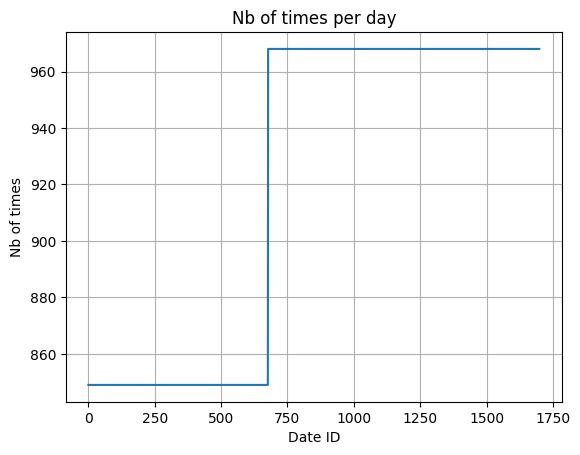

In [34]:
# Extract date_id and nb_times as NumPy arrays
x = time_id_per_day["date_id"].to_numpy()
y = time_id_per_day["nb_times"].to_numpy()

# Plot the data
plt.plot(x, y)
plt.xlabel("Date ID")
plt.ylabel("Nb of times")
plt.title("Nb of times per day")
plt.grid()
plt.show()


In [35]:
# Get the unique values of the 'nb_times' column and print them
unique_nb_times = np.unique(time_id_per_day["nb_times"].to_numpy())
print("Unique number of dates:", unique_nb_times)

Unique number of dates: [849 968]


In [36]:
# Define the value you're filtering for
value = 968

# Filter the DataFrame where 'nb_times' is equal to the specified value
filtered_df = time_id_per_day.filter(pl.col("nb_times") == value)

# Display the first few rows of the filtered DataFrame
filtered_df.head()


date_id,nb_times
i16,u32
677,968
678,968
679,968
680,968
681,968


In [37]:
# Group by 'date_id' and count unique 'symbol_id' values per day
symbols_per_day = pl_train.group_by("date_id").agg([pl.col("symbol_id").n_unique().alias("nb_symbols")])

# Sort by 'date_id'
symbols_per_day = symbols_per_day.sort('date_id')

# Optionally, check the first few rows of the result
print(symbols_per_day.head())


shape: (5, 2)
┌─────────┬────────────┐
│ date_id ┆ nb_symbols │
│ ---     ┆ ---        │
│ i16     ┆ u32        │
╞═════════╪════════════╡
│ 0       ┆ 8          │
│ 1       ┆ 12         │
│ 2       ┆ 11         │
│ 3       ┆ 12         │
│ 4       ┆ 12         │
└─────────┴────────────┘


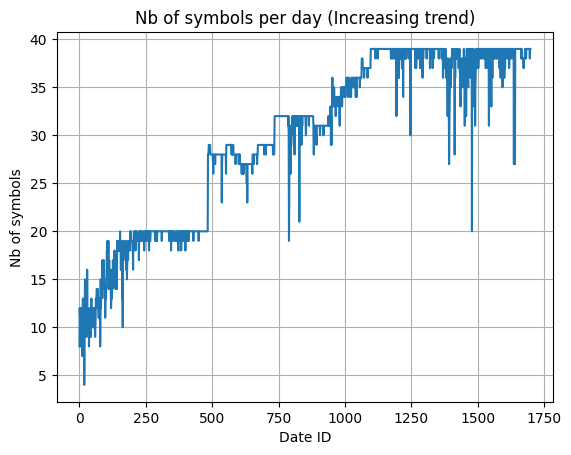

In [38]:
# Extract date_id and nb_symbols as NumPy arrays
x = symbols_per_day["date_id"].to_numpy()
y = symbols_per_day["nb_symbols"].to_numpy()

# Plot the data with an increasing trend
plt.plot(x, y)
plt.xlabel("Date ID")
plt.ylabel("Nb of symbols")
plt.title("Nb of symbols per day (Increasing trend)")
plt.grid(True)

# Display the plot
plt.show()


In [39]:
pl_train.head()

date_id,time_id,symbol_id,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
0,0,7,2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639
0,0,9,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
0,0,10,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
0,0,14,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.0,-3.57282,-1.089123,-5.0


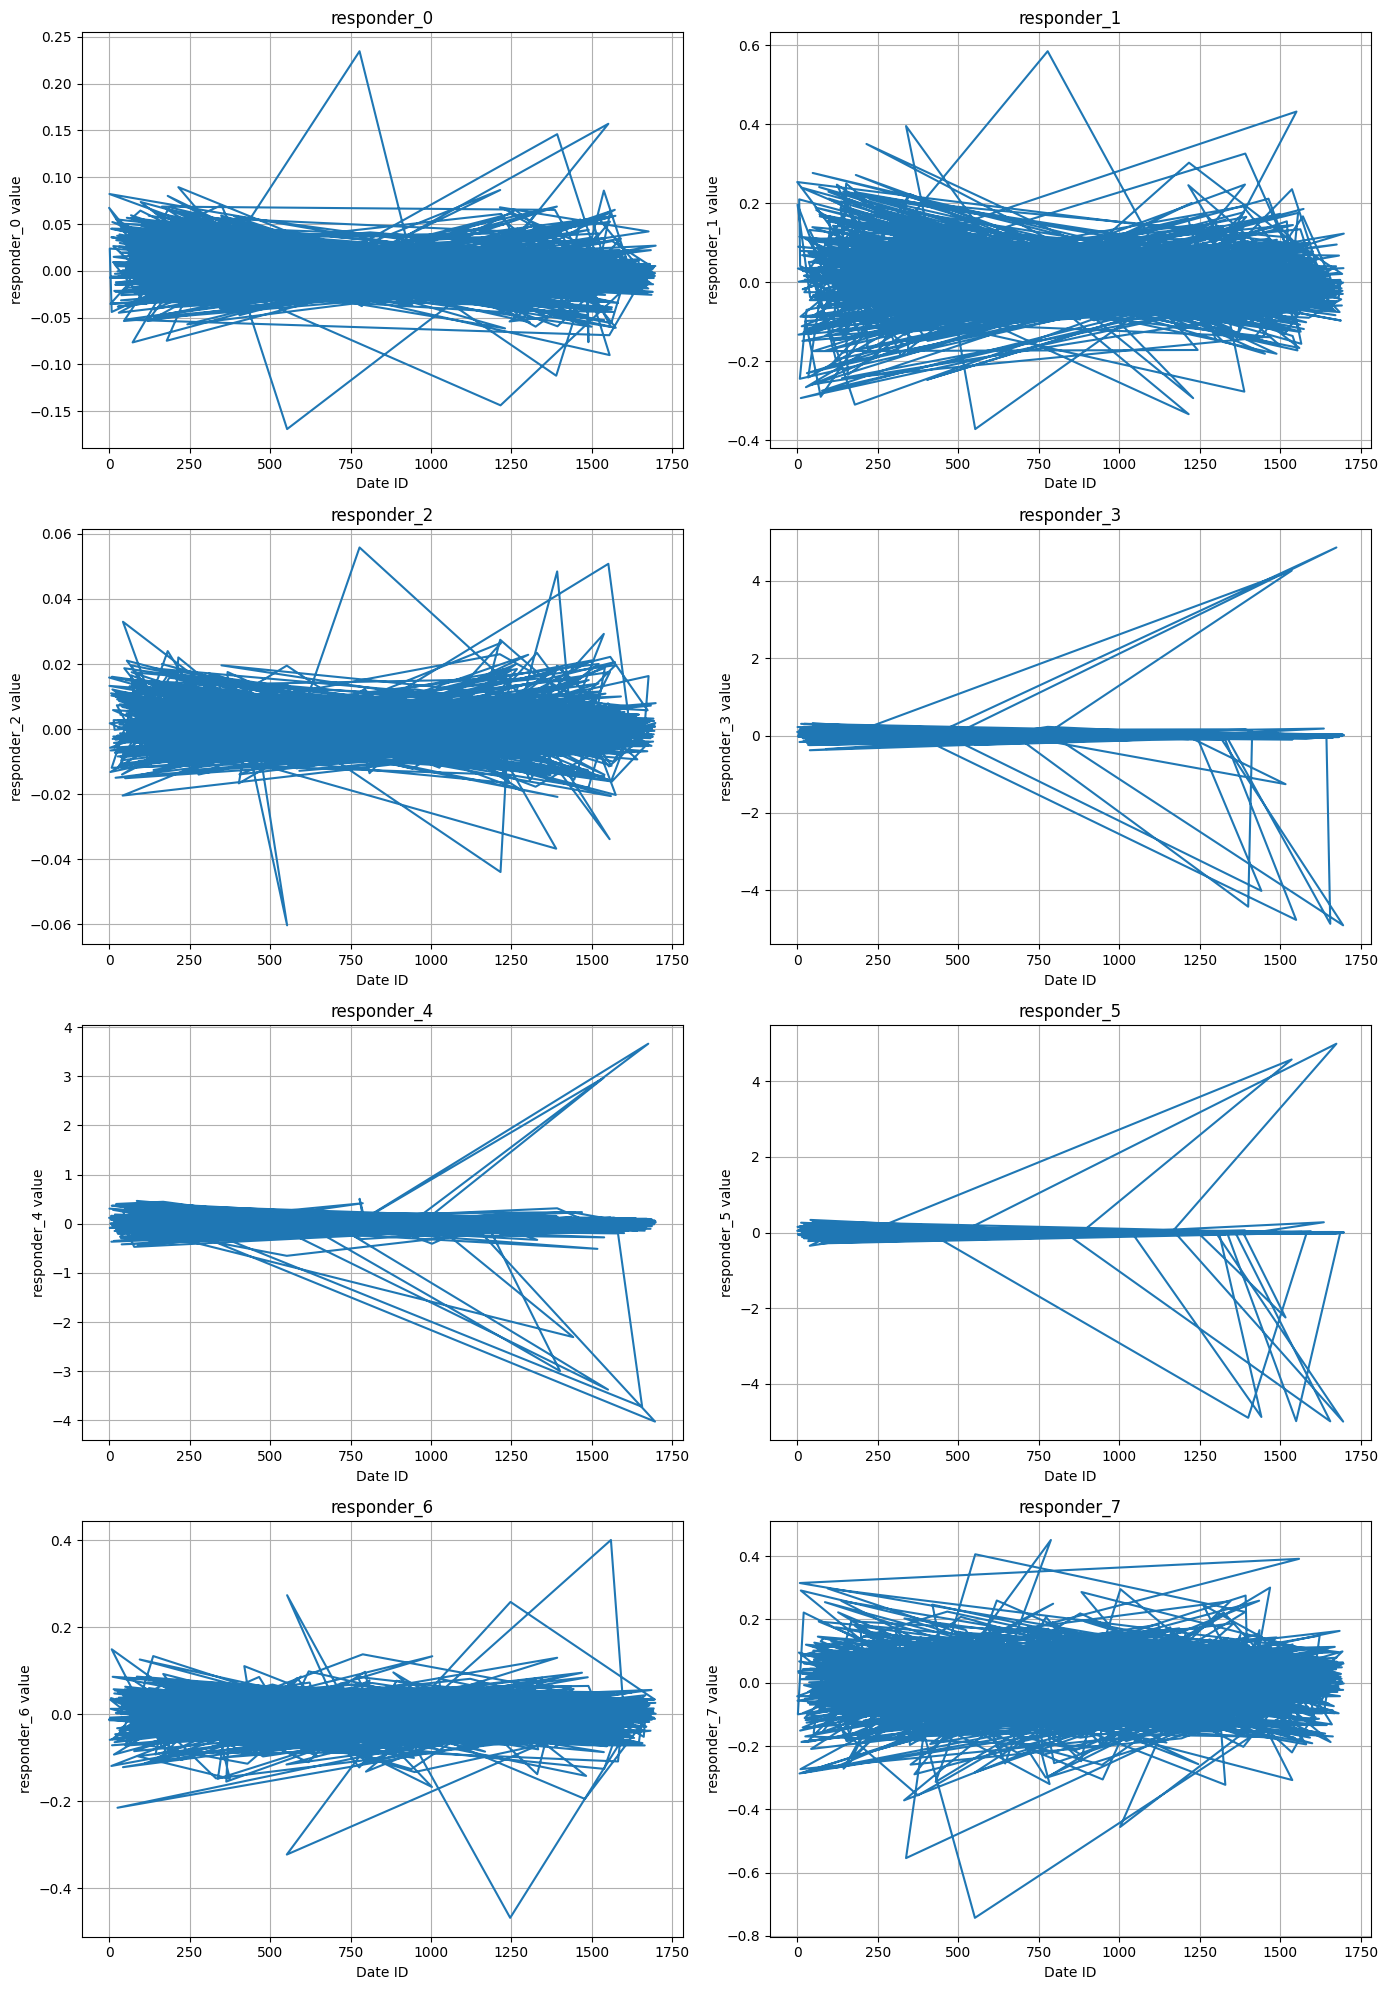

In [40]:
# Create a 4x2 grid of subplots with the specified figure size
fig, axes = plt.subplots(4, 2, figsize=(14, 20))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop over the responder columns (from 0 to 7)
for i in range(8):
    col_name = f'responder_{i}'
    
    # Group by 'date_id' and compute the mean for each 'responder_i' column
    resp = pl_train.group_by("date_id").agg(pl.col(col_name).mean().alias(col_name))
    
    # Plot the mean value of each responder over time (date_id)
    axes[i].plot(resp['date_id'].to_numpy(), resp[col_name].to_numpy())
    
    # Set the title for each subplot
    axes[i].set_title(col_name)
    
    # Add grid lines for better readability
    axes[i].grid(True)
    
    # Set labels for x and y axes
    axes[i].set_xlabel("Date ID")
    axes[i].set_ylabel(f"{col_name} value")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


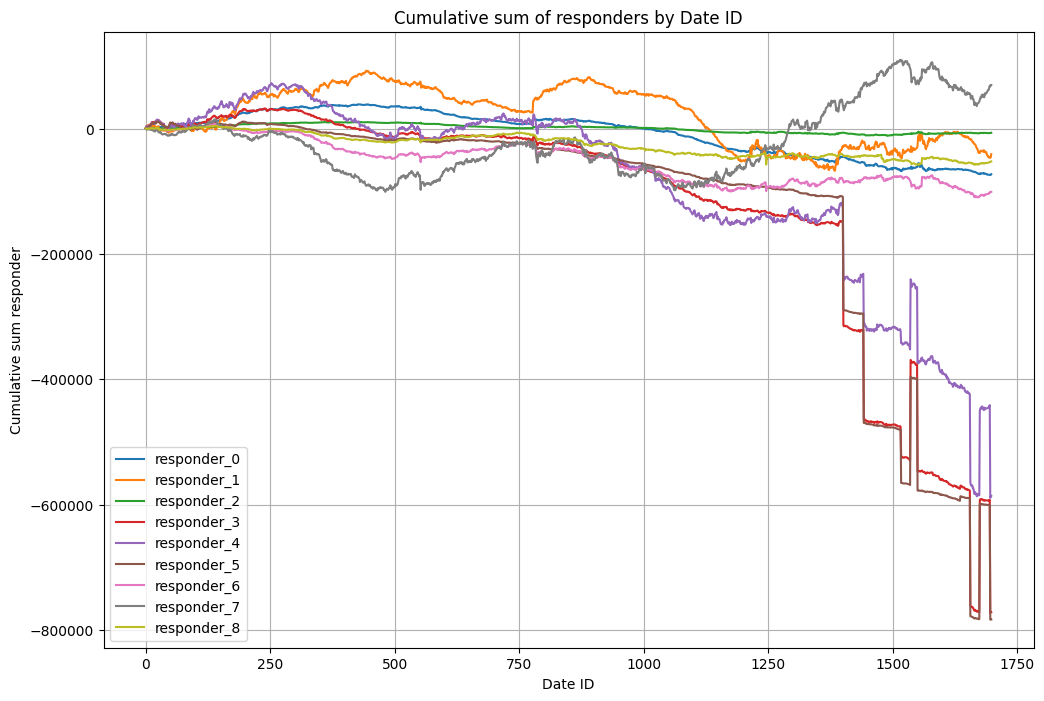

In [41]:
# Create a figure with the specified size
plt.figure(figsize=(12, 8))

# Loop through the responder columns (from 0 to 8)
for i in range(9):
    # Group by 'date_id' and calculate the sum of each responder column
    resp = pl_train.group_by("date_id").agg(pl.col(f"responder_{i}").sum().alias("responder_sum"))
    resp = resp.sort('date_id')  # Sort by date_id to ensure the time series is in order
    
    # Get the 'date_id' and cumulative sum of 'responder_sum'
    x = resp["date_id"].to_numpy()
    y = np.cumsum(resp['responder_sum'].to_numpy())

    # Plot the cumulative sum for each responder
    plt.plot(x, y, label=f'responder_{i}')

# Add labels, title, grid, and legend
plt.xlabel("Date ID")
plt.ylabel("Cumulative sum responder")
plt.title("Cumulative sum of responders by Date ID")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


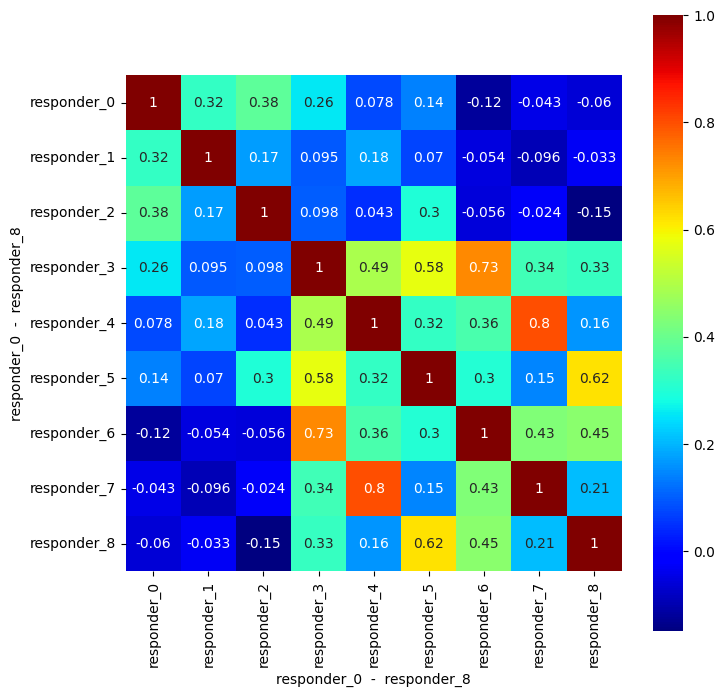

In [42]:
# Create a figure with the specified size
plt.figure(figsize=(8, 8))

# Select the responder columns and calculate their correlation matrix
sns.heatmap(pl_train[[f"responder_{target}" for target in range(9)]].to_pandas().corr(), 
            annot=True,    # Annotate each cell with the numeric value
            square=True,   # Ensure the heatmap is square
            cmap="jet")    # Use the 'jet' colormap for the heatmap

# Add labels for the axes
plt.xlabel("responder_0  -  responder_8")
plt.ylabel("responder_0  -  responder_8")

# Show the plot
plt.show()


In [43]:
# List of feature columns (feature_00 to feature_78)
feature_cols = [f'feature_{x:02}' for x in range(79)]

# Target column (responder_6)
target_column = "responder_6"

# Extend fields list with feature columns, target column, and weight
fields = []
fields.extend(feature_cols)  # Adding all feature columns
fields.extend([target_column])  # Adding the target column (responder_6)
fields.extend(['weight'])  # Adding the weight column


In [44]:
summaries = []

# Iterate through each parquet file in train_parquets
for batch_file in train_parquets:
    # Load the parquet file with only the selected fields
    pl_train = pl.read_parquet(batch_file, columns=fields)
    
    # Get summary statistics (descriptive statistics)
    summaries.append(pl_train.describe())  # Appending the summary of the batch data to the list


In [45]:
# Print the summary of a particular column, for example 'feature_00'
for summary in summaries:
    print(summary.select('feature_00'))

shape: (9, 1)
┌────────────┐
│ feature_00 │
│ ---        │
│ f64        │
╞════════════╡
│ 0.0        │
│ 1.94421e6  │
│ null       │
│ null       │
│ null       │
│ null       │
│ null       │
│ null       │
│ null       │
└────────────┘
shape: (9, 1)
┌────────────┐
│ feature_00 │
│ ---        │
│ f64        │
╞════════════╡
│ 1.566405e6 │
│ 1.237842e6 │
│ -0.431989  │
│ 0.989483   │
│ -4.156833  │
│ -1.068465  │
│ -0.360322  │
│ 0.260764   │
│ 2.452839   │
└────────────┘
shape: (9, 1)
┌────────────┐
│ feature_00 │
│ ---        │
│ f64        │
╞════════════╡
│ 3.036873e6 │
│ 0.0        │
│ 0.826814   │
│ 0.95154    │
│ -2.506287  │
│ 0.096034   │
│ 0.913496   │
│ 1.552006   │
│ 4.19437    │
└────────────┘
shape: (9, 1)
┌────────────┐
│ feature_00 │
│ ---        │
│ f64        │
╞════════════╡
│ 4.016784e6 │
│ 0.0        │
│ 0.678833   │
│ 0.783954   │
│ -2.53001   │
│ 0.143403   │
│ 0.669604   │
│ 1.173076   │
│ 6.069376   │
└────────────┘
shape: (9, 1)
┌────────────┐
│ feature_00 │


In [46]:
len(summaries)

10

In [47]:
summaries[1]

statistic,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,…,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,weight
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.566405e6,1.566405e6,1.566405e6,1.566405e6,1.566405e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.724958e6,2.804206e6,2.79098e6,2.804218e6,2.804218e6,2.804247e6,0.0,2.804247e6,2.804247e6,2.804247e6,2.804247e6,0.0,0.0,2.804247e6,2.804247e6,2.804247e6,0.0,2.772792e6,2.772792e6,2.804247e6,2.804247e6,…,2.701791e6,2.714187e6,2.714187e6,2.804247e6,2.804247e6,2.804247e6,2.381463e6,2.800944e6,2.711763e6,2.381463e6,2.800944e6,2.711763e6,2.804218e6,2.804218e6,2.772792e6,2.804247e6,2.804247e6,2.804247e6,2.722423e6,2.741088e6,2.738229e6,2.714187e6,2.714187e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.772792e6,2.772792e6,2.804201e6,2.804201e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6
"""null_count""",1.237842e6,1.237842e6,1.237842e6,1.237842e6,1.237842e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79289.0,41.0,13267.0,29.0,29.0,0.0,2.804247e6,0.0,0.0,0.0,0.0,2.804247e6,2.804247e6,0.0,0.0,0.0,2.804247e6,31455.0,31455.0,0.0,0.0,…,102456.0,90060.0,90060.0,0.0,0.0,0.0,422784.0,3303.0,92484.0,422784.0,3303.0,92484.0,29.0,29.0,31455.0,0.0,0.0,0.0,81824.0,63159.0,66018.0,90060.0,90060.0,0.0,0.0,0.0,0.0,0.0,0.0,31455.0,31455.0,46.0,46.0,0.0,0.0,0.0,0.0
"""mean""",-0.431989,0.017173,-0.432324,-0.43178,0.000035,0.040265,0.006898,0.020787,-0.036623,33.53073,4.381169,180.130487,-0.044282,-0.003089,-0.008241,-0.053217,-0.065402,-0.055736,0.018417,0.071568,0.36973,null,-0.015542,0.008409,-0.413032,-0.150604,null,null,0.176169,-0.190091,-0.073405,null,-0.130222,0.001822,-0.13429,-0.133683,…,0.148989,-0.055956,0.100762,0.011658,0.002712,0.006955,0.032823,-0.080915,-0.012614,-0.033002,0.119949,0.046262,-0.03215,0.024793,0.025386,0.004274,0.012777,0.019043,0.326323,0.245984,0.271748,0.133246,0.149727,-0.057291,-0.009207,-0.018697,-0.033711,0.001473,0.000088,0.01863,0.021636,0.0181,0.020503,0.015294,0.017931,-0.006968,1.866079
"""std""",0.989483,0.824999,0.990223,0.989088,0.834556,1.083555,1.079575,1.096134,0.932426,25.973282,2.327365,182.248617,0.844735,0.914271,0.84886,0.648965,0.736986,0.689909,1.040135,1.035307,0.981225,null,0.980912,0.940911,0.837487,0.953337,null,null,0.933869,0.530387,0.634874,null,0.93087,1.132248,0.884795,0.886861,…,1.256132,1.15151,1.146161,1.142599,1.255402,1.139592,1.044497,1.026993,1.03378,1.037912,1.020283,1.04003,1.070556,1.043223,1.045631,1.028131,1.019608,1.024071,1.255467,1.258148,1.266446,0.985064,0.989225,0.813053,0.830689,0.807359,0.894107,1.028476,0.930081,0.857871,0.862717,1.004383,1.002674,0.872946,0.866843,0.900644,1.078664
"""min""",-4.156833,-3.67637,-3.636927,-3.943468,-3.984868,-20.425817,-42.277046,-25.808468,-11.642641,4.0,1.0,11.0,-1.74153,-0.894513,-1.302579,-1.476584,-1.642047,-1.672714,-4.278796,-5.772067,-2.649718,null,-2.068377,-2.28122,-2.588802,-1.833118,null,null,-2.813438,-1.009998,-1.299397,null,-4.189541,-4.2

In [48]:
import numpy as np

def r2_score(y_true, y_pred, weights):
    """
    Calculate the sample weighted zero-mean R-squared score (R2).

    Parameters:
    - y_true (np.array or pd.Series): Ground truth values.
    - y_pred (np.array or pd.Series): Predicted values.
    - weights (np.array or pd.Series): Sample weights.

    Returns:
    - float: R2 score.
    """
    # Calculate the weighted sum of squared residuals
    numerator = np.sum(weights * (y_true - y_pred) ** 2)
    
    # Calculate the weighted sum of squared true values
    denominator = np.sum(weights * (y_true ** 2))
    
    # R2 score formula
    r2 = 1 - (numerator / denominator)
    return r2

def evaluate_model(model, test_data, cols=feature_cols, target_column="responder_6"):
    """
    Evaluate the model on test data using the R2 score.

    Parameters:
    - model: The trained model to evaluate.
    - test_data (pd.DataFrame or np.array): Test dataset.
    - cols (list): List of feature column names.
    - target_column (str): The name of the target column in the dataset.

    Returns:
    - None
    """
    # Predictions from the model
    y_pred = model.predict(test_data[cols])
    
    # Actual values (ground truth)
    y_true = test_data[target_column].to_numpy()
    
    # Sample weights
    weights = test_data['weight'].to_numpy()

    # Calculate R2 score
    score = r2_score(y_true, y_pred, weights)
    print(f"Sample weighted zero-mean R-squared score (R2) on test data: {score}")


In [49]:
import numpy as np
import polars as pl

# Read and concatenate parquet files into a single Polars DataFrame
pl_train = pl.concat([pl.read_parquet(_f, columns=['weight', 'responder_6']) for _f in train_parquets])

# Create constant submission prediction array (all ones)
submission_constant = np.ones(len(pl_train))

# Extract ground truth (responder_6) and weights from pl_train
gt = pl_train['responder_6'].to_numpy()  # Ground truth
wg = pl_train['weight'].to_numpy()  # Sample weights


In [50]:
R2_constant = r2_score(wg, submission_constant, gt)
R2_constant

0.5698739909302737

In [51]:
from sklearn.linear_model import LinearRegression
# Initialize the model
model = LinearRegression()
# the column we want to predict
target_column = "responder_6"

In [52]:
fields = []
fields.extend(feature_cols)
fields.extend([target_column])
fields.extend(['weight'])

In [53]:
pl_train = pl.concat([pl.read_parquet(_f, columns=fields) for _f in train_parquets])

In [54]:
# Number of rows to sample (1/5th of the total dataset)
num_rows_to_sample = len(pl_train) // 5

# Randomly sample the dataset
pl_train = pl_train.sample(n=num_rows_to_sample)

# Select the feature columns and target column
X_train = pl_train.select(feature_cols).to_numpy()
y_train = pl_train.select(target_column).to_numpy().flatten()

# Replace NaN values with 0
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)


In [55]:
model.fit(X_train, y_train)

LinearRegression()

In [56]:
submission_linear = []
for batch_file in train_parquets:
    # Load batch data
    pl_train = pl.read_parquet(batch_file, columns=fields)
    pl_train = pl_train.fill_null(0)  # Replace nulls with 0
    
    # Extract features and target
    if feature_cols is None:
        feature_cols = [col for col in pl_train.columns if col != target_column]
    
    X = pl_train.select(feature_cols).to_numpy()
    
    # Make predictions using the trained model
    y_pred = model.predict(X).tolist()
    
    # Collect the predictions for later use
    submission_linear.extend(y_pred)


In [57]:
R2_linear = r2_score(wg, submission_linear, gt)
R2_linear

-1.155374861354454

In [58]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [59]:
fields = []
fields.extend(feature_cols)  # Add feature columns
fields.extend([target_column])  # Add target column
fields.extend(['weight'])  # Add weight column

# Concatenate data from all parquet files
pl_train = pl.concat([pl.read_parquet(_f, columns=fields) for _f in train_parquets])


In [60]:
# Calculate the number of rows to sample (one-fifth of the dataset)
num_rows_to_sample = len(pl_train) // 5

# Sample the data to reduce the size of the DataFrame
pl_train = pl_train.sample(n=num_rows_to_sample)


In [61]:
len(summaries)

10

In [62]:
summaries[1]

statistic,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,…,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,weight
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.566405e6,1.566405e6,1.566405e6,1.566405e6,1.566405e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.724958e6,2.804206e6,2.79098e6,2.804218e6,2.804218e6,2.804247e6,0.0,2.804247e6,2.804247e6,2.804247e6,2.804247e6,0.0,0.0,2.804247e6,2.804247e6,2.804247e6,0.0,2.772792e6,2.772792e6,2.804247e6,2.804247e6,…,2.701791e6,2.714187e6,2.714187e6,2.804247e6,2.804247e6,2.804247e6,2.381463e6,2.800944e6,2.711763e6,2.381463e6,2.800944e6,2.711763e6,2.804218e6,2.804218e6,2.772792e6,2.804247e6,2.804247e6,2.804247e6,2.722423e6,2.741088e6,2.738229e6,2.714187e6,2.714187e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6,2.772792e6,2.772792e6,2.804201e6,2.804201e6,2.804247e6,2.804247e6,2.804247e6,2.804247e6
"""null_count""",1.237842e6,1.237842e6,1.237842e6,1.237842e6,1.237842e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79289.0,41.0,13267.0,29.0,29.0,0.0,2.804247e6,0.0,0.0,0.0,0.0,2.804247e6,2.804247e6,0.0,0.0,0.0,2.804247e6,31455.0,31455.0,0.0,0.0,…,102456.0,90060.0,90060.0,0.0,0.0,0.0,422784.0,3303.0,92484.0,422784.0,3303.0,92484.0,29.0,29.0,31455.0,0.0,0.0,0.0,81824.0,63159.0,66018.0,90060.0,90060.0,0.0,0.0,0.0,0.0,0.0,0.0,31455.0,31455.0,46.0,46.0,0.0,0.0,0.0,0.0
"""mean""",-0.431989,0.017173,-0.432324,-0.43178,0.000035,0.040265,0.006898,0.020787,-0.036623,33.53073,4.381169,180.130487,-0.044282,-0.003089,-0.008241,-0.053217,-0.065402,-0.055736,0.018417,0.071568,0.36973,null,-0.015542,0.008409,-0.413032,-0.150604,null,null,0.176169,-0.190091,-0.073405,null,-0.130222,0.001822,-0.13429,-0.133683,…,0.148989,-0.055956,0.100762,0.011658,0.002712,0.006955,0.032823,-0.080915,-0.012614,-0.033002,0.119949,0.046262,-0.03215,0.024793,0.025386,0.004274,0.012777,0.019043,0.326323,0.245984,0.271748,0.133246,0.149727,-0.057291,-0.009207,-0.018697,-0.033711,0.001473,0.000088,0.01863,0.021636,0.0181,0.020503,0.015294,0.017931,-0.006968,1.866079
"""std""",0.989483,0.824999,0.990223,0.989088,0.834556,1.083555,1.079575,1.096134,0.932426,25.973282,2.327365,182.248617,0.844735,0.914271,0.84886,0.648965,0.736986,0.689909,1.040135,1.035307,0.981225,null,0.980912,0.940911,0.837487,0.953337,null,null,0.933869,0.530387,0.634874,null,0.93087,1.132248,0.884795,0.886861,…,1.256132,1.15151,1.146161,1.142599,1.255402,1.139592,1.044497,1.026993,1.03378,1.037912,1.020283,1.04003,1.070556,1.043223,1.045631,1.028131,1.019608,1.024071,1.255467,1.258148,1.266446,0.985064,0.989225,0.813053,0.830689,0.807359,0.894107,1.028476,0.930081,0.857871,0.862717,1.004383,1.002674,0.872946,0.866843,0.900644,1.078664
"""min""",-4.156833,-3.67637,-3.636927,-3.943468,-3.984868,-20.425817,-42.277046,-25.808468,-11.642641,4.0,1.0,11.0,-1.74153,-0.894513,-1.302579,-1.476584,-1.642047,-1.672714,-4.278796,-5.772067,-2.649718,null,-2.068377,-2.28122,-2.588802,-1.833118,null,null,-2.813438,-1.009998,-1.299397,null,-4.189541,-4.2

In [63]:
import numpy as np

def r2_score(y_true, y_pred, weights):
    """
    Calculate the sample weighted zero-mean R-squared score (R2).

    Parameters:
    - y_true (np.array): Ground truth values.
    - y_pred (np.array): Predicted values.
    - weights (np.array): Sample weights.

    Returns:
    - float: R2 score.
    """
    numerator = np.sum(weights * (y_true - y_pred) ** 2)
    denominator = np.sum(weights * (y_true ** 2))
    r2 = 1 - (numerator / denominator)  # Zero-mean R^2 calculation
    return r2

def evaluate_model(model, test_data, cols, target_column="responder_6"):
    # Get predictions from the model
    y_pred = model.predict(test_data[cols])

    # Get true values and weights from test data
    y_true = test_data[target_column].to_numpy()
    weights = test_data['weight'].to_numpy()

    # Calculate R2 score using the custom function
    score = r2_score(y_true, y_pred, weights)
    
    print(f"Sample weighted zero-mean R-squared score (R2) on test data: {score}")


In [64]:
R2_constant = r2_score(wg, submission_constant, gt)
R2_constant

0.5698739909302737

In [65]:
fields = []
fields.extend(feature_cols)
fields.extend([target_column])
fields.extend(['weight'])

In [66]:
pl_train = pl.concat([pl.read_parquet(_f, columns=fields) for _f in train_parquets])

In [67]:
# Sampling the data
num_rows_to_sample = len(pl_train) // 5
pl_train = pl_train.sample(n=num_rows_to_sample)

# Prepare the training features and target
X_train = pl_train.select(feature_cols).to_numpy()
y_train = pl_train.select(target_column).to_numpy().flatten()

# Ensure no NaN values in X_train and y_train
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

# Prepare weights
weights = pl_train.select("weight").to_numpy().flatten()
weights = np.nan_to_num(weights)  # Handle any NaN values in weights


In [68]:
model.fit(X_train, y_train)

LinearRegression()

In [69]:
submission_linear = []

for batch_file in train_parquets:
    # Load batch data
    pl_train = pl.read_parquet(batch_file, columns=fields)
    pl_train = pl_train.fill_null(0)  # Handle missing values by filling with zeros

    # Extract features and target
    if feature_cols is None:
        feature_cols = [col for col in pl_train.columns if col != target_column]
    
    X = pl_train.select(feature_cols).to_numpy()  # Features
    y_pred = model.predict(X).tolist()  # Model predictions
    
    submission_linear.extend(y_pred)  # Add predictions to submission list


In [70]:
R2_linear = r2_score(wg, submission_linear, gt)
R2_linear

-1.1623263035644618

In [71]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [72]:
fields = []
fields.extend(feature_cols)
fields.extend([target_column])
fields.extend(['weight'])
pl_train = pl.concat([pl.read_parquet(_f, columns=fields) for _f in train_parquets])

In [73]:
num_rows_to_sample = len(pl_train) // 5
pl_train = pl_train.sample(n=num_rows_to_sample)

In [74]:
import numpy as np

# Extracting features, target, and weights
X = pl_train.select(feature_cols).to_numpy()
y = pl_train.select(target_column).to_numpy().flatten()
weights = pl_train.select("weight").to_numpy().flatten()

# Convert any NaN values to 0 (or any other number you'd prefer, such as the column mean)
X = np.nan_to_num(X)
y = np.nan_to_num(y)
weights = np.nan_to_num(weights)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
weights_train, weights_test = train_test_split(weights, test_size=0.2, random_state=42)

In [76]:
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights_train)  # Training set
dtest = xgb.DMatrix(X_test, label=y_test, weight=weights_test)    # Test set

In [77]:
import numpy as np
import xgboost as xgb

def r2_metric(predt: np.ndarray, dtrain: xgb.DMatrix):
    '''Compute r2 metric for xgboost'''
    y_true = dtrain.get_label()
    
    # Check if weights are provided; if not, assume uniform weights
    weights = dtrain.get_weight() if dtrain.get_weight() is not None else np.ones_like(y_true)
    
    # Weighted R2 calculation
    numerator = np.sum(weights * (y_true - predt) ** 2)
    denominator = np.sum(weights * (y_true ** 2))
    r2_score = 1 - (numerator / denominator)
    
    return ('R2', float(r2_score))


In [78]:
import xgboost as xgb

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 4,                   # Maximum depth of the tree
    'eta': 0.1,                       # Learning rate
    'eval_metric': 'rmse',             # Evaluation metric
    'seed': 42,                        # Random seed for reproducibility
}

# Assuming dtrain is the training data (xgb.DMatrix) and dtest is the test data (xgb.DMatrix)
model = xgb.train(
    params,
    dtrain,
    num_boost_round=50,
    evals=[(dtest, 'test')],           # Provide the test set for evaluation
    custom_metric=r2_metric,          # Custom R2 metric function
    verbose_eval=True,
    early_stopping_rounds=10          # Stop training if no improvement in 10 rounds
)


[0]	test-rmse:0.84910	test-R2:0.00081
[1]	test-rmse:0.84882	test-R2:0.00147
[2]	test-rmse:0.84857	test-R2:0.00204
[3]	test-rmse:0.84835	test-R2:0.00257
[4]	test-rmse:0.84814	test-R2:0.00306
[5]	test-rmse:0.84797	test-R2:0.00345
[6]	test-rmse:0.84779	test-R2:0.00388
[7]	test-rmse:0.84760	test-R2:0.00432
[8]	test-rmse:0.84747	test-R2:0.00464
[9]	test-rmse:0.84731	test-R2:0.00500
[10]	test-rmse:0.84718	test-R2:0.00532


In [79]:
submission_xgboost = []

# Ensure feature_cols is defined before the loop if not already
if feature_cols is None:
    feature_cols = [col for col in pl_train.columns if col != target_column]

# Loop over batches to make predictions
for batch_file in train_parquets:
    # Load batch data
    pl_train = pl.read_parquet(batch_file, columns=fields)
    pl_train = pl_train.fill_null(0)  # Handle missing values (you may want to change this strategy)
    
    # Extract features
    X = pl_train.select(feature_cols).to_numpy()
    
    # Convert to DMatrix format for XGBoost
    X_dmatrix = xgb.DMatrix(X)  # Convert features to DMatrix for prediction
    
    # Make predictions
    y_pred = model.predict(X_dmatrix).tolist()  # Predict using the trained model
    
    # Store predictions
    submission_xgboost.extend(y_pred)

# submission_xgboost now contains predictions for all batches


In [80]:
R2_xgboost = r2_score(wg, submission_xgboost, gt)
R2_xgboost

-0.5584972450291381

In [81]:
fields = []
fields.extend(responder_cols)
fields.extend(['date_id', 'symbol_id'])
lag_cols_rename = { f"responder_{idx}" : f"responder_{idx}_lag_1" for idx in range(9)}
pl_train = pl.concat([pl.read_parquet(_f, columns=fields) for _f in train_parquets])

In [82]:
lag_cols_rename = { f"responder_{idx}" : f"responder_{idx}_lag_1" for idx in range(9)}

In [83]:
print(pl_train.columns)

['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_6', 'responder_7', 'responder_8', 'date_id', 'symbol_id']


In [84]:
lags = pl_train.rename(lag_cols_rename)

In [85]:
print(lags.columns)

['responder_0_lag_1', 'responder_1_lag_1', 'responder_2_lag_1', 'responder_3_lag_1', 'responder_4_lag_1', 'responder_5_lag_1', 'responder_6_lag_1', 'responder_7_lag_1', 'responder_8_lag_1', 'date_id', 'symbol_id']


In [86]:
lags = lags.with_columns(
    date_id = pl.col('date_id') + 1,  # lagged by 1 day
)

In [87]:
lags = lags.group_by(["date_id", "symbol_id"], maintain_order=True).last()

In [88]:
lags.head()

date_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,1,1.382971,0.416069,3.134381,1.032238,0.580303,1.853194,0.01209,0.040493,0.013765
1,7,0.635954,0.173196,3.124839,1.068124,0.436262,1.311089,0.116055,0.073651,0.164904
1,9,0.248801,-0.104118,-0.110137,0.168204,0.112685,0.459633,0.041742,0.04499,0.063626
1,10,-1.626361,-0.753249,-0.433064,-1.753868,-0.806781,-2.706254,-0.455618,-0.197604,-0.864137
1,14,5.0,3.496727,5.0,4.731386,2.209459,5.0,0.36648,0.315538,0.699698


In [89]:
pl_train.shape

(47127338, 11)

In [90]:
lags.shape

(50382, 11)

In [91]:
pl_train = pl_train.join(lags, on=["date_id", "symbol_id"],  how="left")
pl_train.head()

responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,date_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32
0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504,0,1,null,null,null,null,null,null,null,null,null
2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639,0,7,null,null,null,null,null,null,null,null,null
-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828,0,9,null,null,null,null,null,null,null,null,null
0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516,0,10,null,null,null,null,null,null,null,null,null
-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.0,-3.57282,-1.089123,-5.0,0,14,null,null,null,null,null,null,null,null,null


In [92]:
pl_train = pl_train.drop(responder_cols)

In [93]:
pl_train.head()

date_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,1,null,null,null,null,null,null,null,null,null
0,7,null,null,null,null,null,null,null,null,null
0,9,null,null,null,null,null,null,null,null,null
0,10,null,null,null,null,null,null,null,null,null
0,14,null,null,null,null,null,null,null,null,null


In [94]:
pl_train.filter(pl.col('date_id') != 0).tail()

date_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,34,0.501321,0.905332,-0.819582,-0.564046,-0.223018,-0.283954,-0.045938,0.009797,-0.102538
1698,35,-1.113053,0.69719,-1.619031,-1.222743,-0.706082,-0.291133,0.167733,0.099704,0.32461
1698,36,-1.019353,-0.460962,-2.026678,-0.848606,-0.305448,-1.256913,-0.109359,-0.027474,-0.253956
1698,37,0.23585,0.556479,0.618944,-0.243765,-0.108361,-0.260777,-0.486923,-0.275566,-1.020708
1698,38,0.542563,0.513193,0.814393,0.032767,0.025435,0.311465,-0.044797,0.011133,-0.0793


In [95]:
pl_train.write_parquet("train_lags.parquet")